<a href="https://colab.research.google.com/github/Javcm/Deep-Learning/blob/main/Batch_Normalization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center>Batch Normalization <center>

Batch normalization es una técnica que nos permite reducir el impacto del  internal covariance shift que es el fenómeno mediante el cuál la distribución de los datos que entra a cada capa cambia en cada iteración del entrenamiento, de modo que  ligeramente distinta al de entrenamiento, de modo que el entrenamiento del modelo es tardado pues se debe usar un learning rate pequeño y es poco estable a la elección inicial de los parámetros [1].

La estrategia que propone Batch normalization es realizar una normalización con los estimadores empíricos de varianza y media a los datos, en principio esto puede realizarse entre cada capa, pero la elección sobre el punto en que se hace esta transformación es parte de la construcción de la arquitectura de la red. 


Un par de ejemplos sobre el uso de esta técnica son:

La arquitectura ResNet propuesta por Kaiming He, Xiangyu Zhang et al, investigadores de Microsoft Research,  es una red neuronal con un porcentaje de error de 3.47% clasificando imágenes de ImageNet, usa batch normalization después de cada capa de convolución [2].

La arquitectura Inception-v3 propuesta por Christian Szegedy, Vincent Vanhoucke, et al, investigadores de Google Research, presentan su mejor desempeño al usar Batch normalization [3].


## Referencias

[1] Ioffe, S., & Szegedy, C. (2015). Batch normalization: Accelerating deep network training by reducing internal covariate shift. arXiv preprint arXiv:1502.03167.

[2] He, K., Zhang, X., Ren, S., & Sun, J. (2016). Deep residual learning for image recognition. In Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 770-778).

[3] Szegedy, C., Vanhoucke, V., Ioffe, S., Shlens, J., & Wojna, Z. (2016). Rethinking the inception architecture for computer vision. In Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 2818-2826).



In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import seaborn as snb; snb.set()
iris = load_iris()
df = pd.DataFrame(iris.data, columns=iris.feature_names).astype(float)
df['label'] = iris.target
df['label'] = df.label.replace(dict(enumerate(iris.target_names)))

label = pd.get_dummies(df['label'], prefix='label')
df = pd.concat([df, label], axis=1)
df.drop(['label'], axis=1, inplace=True)

X = np.asarray(df[['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']])
y = np.asarray(df[['label_setosa', 'label_versicolor', 'label_virginica']])

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.initializers import RandomNormal, Constant


# Modelo sin batch normalization
model = Sequential([
    Dense(64, input_shape=(4,), activation="relu"),
    Dense(128, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')
]);

model.summary()


# Modelo con batch normalization entre cada capa
model_bn = Sequential([
    Dense(64, input_shape=(4,), activation="relu"),
    BatchNormalization(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dense(64, activation='relu'),
    BatchNormalization(
        momentum=0.95, 
        epsilon=0.005,
        beta_initializer=RandomNormal(mean=0.0, stddev=0.05), 
        gamma_initializer=Constant(value=0.9)),
    Dense(3, activation='softmax')]);
model_bn.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 64)                320       
_________________________________________________________________
dense_7 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_8 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_9 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_10 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_11 (Dense)             (None, 3)                 195       
Total params: 37,763
Trainable params: 37,763
Non-trainable params: 0
__________________________________________________

Total time of training sin BN: 2.5727890329944785
Total time of training con BN: 6.377196010989792


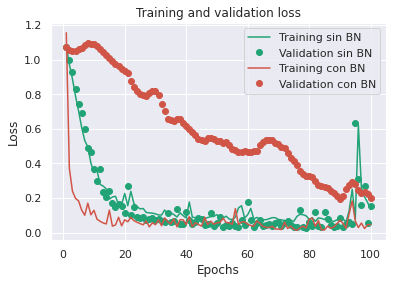

Evaluación sin BN
[0.21535679697990417, 0.8999999761581421]
Evaluación con BN
[0.20311862230300903, 0.9666666388511658]


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, Callback

#early stopping
callback = EarlyStopping(monitor='val_accuracy', patience=4)

#Callback to report time of training
from timeit import default_timer as timer
class TimingCallback(Callback):
    def __init__(self, logs={}):
        self.logs=[]
    def on_epoch_begin(self, epoch, logs={}):
        self.starttime = timer()
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(timer()-self.starttime)
cb = TimingCallback()

model.compile(
    optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_bn.compile(
    optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    X_train, y_train, 
    epochs=100, 
    validation_split=0.25, 
    batch_size=40, 
    callbacks=[cb],verbose=0)
time1=sum(cb.logs)

history_bn = model_bn.fit(
    X_train, y_train, 
    epochs=100, 
    validation_split=0.25, 
    batch_size=40, 
    callbacks=[cb],verbose=0)
time2=sum(cb.logs)


#To compare the training time
print("Total time of training sin BN:",time1)
print("Total time of training con BN:",time2)

#Plotting the history losses for the two models
loss1 = history.history['loss']
val_loss1 = history.history['val_loss']
epochs1 = range(1, len(loss1)+1)
loss2 = history_bn.history['loss']
val_loss2 = history_bn.history['val_loss']
epochs2 = range(1, len(loss2)+1)
plt.plot(epochs1, loss1, 'b', label='Training sin BN',color="#21a376")
plt.plot(epochs1, val_loss1, 'bo', label='Validation sin BN',color="#21a376")
plt.plot(epochs2, loss2, 'b', label='Training con BN',color="#d15547")
plt.plot(epochs2, val_loss2, 'bo', label='Validation con BN',color="#d15547")
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

print("Evaluación sin BN")
print(model.evaluate(X_test, y_test, verbose=0))

print("Evaluación con BN")
print(model_bn.evaluate(X_test, y_test, verbose=0))

En el gráfico de arriba se puede observar que al usar batch normalization se obtiene una mayor precisión en la predicción, sin embargo el tiempo de entrenamiento fue mayor con Batch Normalization, esto es porque usamos el mismo learning rate para ambos, sin embargo la rapidez se vería reflejada al realizar el entrenamiento con un learning rate mayor al usar BN.